# Static train ridership on the Swedish railways 2024.

This is a static analysis of train ridership on the Swedish railways during 2024!

## Read Sampers data

In [1]:
import pandas as pd
import os
import warnings

# Suppress warnings (e.g., from pandas or others)
warnings.filterwarnings("ignore")

# Get the current working directory
current_directory = os.getcwd()

# File path (assuming the CSV file is named 'Sampers-pax-2018-cleaned.csv')
file_path_sampers = os.path.join(current_directory, 'data', 'Sampers-pax-2024-cleaned.csv')

# Read the CSV file into a DataFrame
df_pax = pd.read_csv(file_path_sampers, sep=';', low_memory=False, dtype={"line": str})  # Force 'line' column as string

# Define a function to replace commas with dots and remove hidden characters
def clean_column_values(value):
    if isinstance(value, str):
        value = value.replace(',', '.')  # Replace commas with dots for decimals
        value = value.replace('\r', '').replace('\n', '')  # Remove carriage returns and line breaks
    return value

# Apply cleaning to all columns
for column in df_pax.columns:
    if df_pax[column].dtype == 'object':
        df_pax[column] = df_pax[column].apply(clean_column_values)

# Convert all columns except the first three to numeric
numeric_columns = df_pax.columns[2:]  # Select all columns starting from the 3th (index 2)
df_pax[numeric_columns] = df_pax[numeric_columns].apply(pd.to_numeric, errors='coerce')

## Passengers ombord

A new data structure where the number of passengers ombord is calculated.

In [2]:
# Columns for boardings and alightings
boarding_cols = ["Nat pr PÅ", "Nat tj PÅ", "Nat arb PÅ", "Reg arb PÅ", "Reg tj PÅ", "Reg övr PÅ"]
alighting_cols = ["Nat pr AV", "Nat tj AV", "Nat arb AV", "Reg arb AV", "Reg tj AV", "Reg övr AV"]

# Ensure the relevant columns are floats
df_pax[boarding_cols] = df_pax[boarding_cols].astype(float)
df_pax[alighting_cols] = df_pax[alighting_cols].astype(float)

# Shift the values of alighting columns by one row within each group and replace missing values with zeros
df_pax[alighting_cols] = df_pax.groupby('line')[alighting_cols].shift(+1).fillna(0)

In [3]:
# for each line, compare the total number of boardings and alightings
# if the total number of boardings is greater than the total number of alightings, print the line
for line in df_pax['line'].unique():
    df_line = df_pax[df_pax['line'] == line]
    total_boardings = df_line[boarding_cols].sum().sum()
    total_alightings = df_line[alighting_cols].sum().sum()
    if total_boardings > total_alightings + 1e-3:
        print(f"Line {line} has more boardings ({total_boardings}) than alightings ({total_alightings})")

In [4]:
# Create masks for non-zero boardings and alightings
has_boardings = df_pax[boarding_cols].sum(axis=1) > 0
has_alightings = df_pax[alighting_cols].sum(axis=1) > 0

# Keep rows where either boardings or alightings occur
df_pax = df_pax[has_boardings | has_alightings].reset_index(drop=True)

In [5]:
# Initialize a list to store the results
data = []

# Group by 'line' and process each group separately
for line, group in df_pax.groupby("line"):
    # Reset the index for each group to ensure sequential processing
    group = group.reset_index(drop=True)

    # Initialize onboard counters for each category of passengers
    onboard = {col: 0 for col in boarding_cols}

    for i in range(len(group) - 1):
        # Add boardings at the current station
        for col in boarding_cols:
            onboard[col] += group.loc[i, col]

        # Round and ensure counts are >= 0
        #rounded_onboard = {k: max(round(v), 0) for k, v in onboard.items()}
        # Without rounding nor ensuring counts are >= 0
        rounded_onboard = onboard

        # Subtract alightings for the current station (these apply to the next segment)
        for b_col, a_col in zip(boarding_cols, alighting_cols):
            onboard[b_col] -= group.loc[i, a_col]

        # Append the data for the current segment (from the current station to the next)
        data.append({
            "Linje": line,
            # the first and last station of the line
            "först": group.loc[0, "Station"],
            "sist": group.iloc[-1]["Station"],
            # the pair of stations for the current segment
            "från": group.loc[i, "Station"],
            "till": group.loc[i + 1, "Station"],
            # the number of passengers onboard for the current segment
            "ombord_pr_nat": rounded_onboard["Nat pr PÅ"],
            "ombord_tj_nat": rounded_onboard["Nat tj PÅ"],
            "ombord_arb_nat": rounded_onboard["Nat arb PÅ"],
            "ombord_arb_reg": rounded_onboard["Reg arb PÅ"],
            "ombord_tj_reg": rounded_onboard["Reg tj PÅ"],
            "ombord_övr_reg": rounded_onboard["Reg övr PÅ"],
            # the number of passengers alighting at the next station
            "avstigande_pr_nat": group.loc[i+1, "Nat pr AV"],
            "avstigande_tj_nat": group.loc[i+1, "Nat tj AV"],
            "avstigande_arb_nat": group.loc[i+1, "Nat arb AV"],
            "avstigande_arb_reg": group.loc[i+1, "Reg arb AV"],
            "avstigande_tj_reg": group.loc[i+1, "Reg tj AV"],
            "avstigande_övr_reg": group.loc[i+1, "Reg övr AV"],
            # the number of passengers boarding at the current station
            "påstigande_pr_nat": group.loc[i, "Nat pr PÅ"],
            "påstigande_tj_nat": group.loc[i, "Nat tj PÅ"],
            "påstigande_arb_nat": group.loc[i, "Nat arb PÅ"],
            "påstigande_arb_reg": group.loc[i, "Reg arb PÅ"],
            "påstigande_tj_reg": group.loc[i, "Reg tj PÅ"],
            "påstigande_övr_reg": group.loc[i, "Reg övr PÅ"]
        })

# Convert the list to a DataFrame
new_df_pax = pd.DataFrame(data)

# Filter out rows where the station name is "0" or "A6"
#new_df_pax = new_df_pax[(new_df_pax["från"] != "0") | (new_df_pax["från"] != "A6")].reset_index(drop=True)

## Validations

In [6]:
# check if either från or till is "0" or "A6"
# if so, print the rows
for i in range(len(new_df_pax)):
    if new_df_pax.loc[i, "från"] == "0" or new_df_pax.loc[i, "från"] == "A6":
        print(new_df_pax.loc[i]) 

In [7]:
# rows with the same line number have the same först and sist.
# check if först and sist are the same for each line number
for line in new_df_pax["Linje"].unique():
    if new_df_pax[new_df_pax["Linje"] == line]["först"].nunique() != 1:
        print(line)
    if new_df_pax[new_df_pax["Linje"] == line]["sist"].nunique() != 1:
        print(line)

In [8]:
# for each line number, check if there is an inverse line number, i.e., in the format "line number" + "R"
for line in new_df_pax["Linje"].unique():
    if line[-1] == "R":
        if line[:-1] not in new_df_pax["Linje"].unique():
            print(line)

In [9]:
# check if the pair (först, sist) is the same for a line and its inverse line
for line in new_df_pax["Linje"].unique():
    if line[-1] == "R":
        if new_df_pax[new_df_pax["Linje"] == line]["först"].nunique() != 1:
            print(line)
        if new_df_pax[new_df_pax["Linje"] == line]["sist"].nunique() != 1:
            print(line)
    else:
        if line + "R" not in new_df_pax["Linje"].unique():
            print(line)

Thanks to the following validation, the lines 10002 and 10502 were found to be peculiar so a manual modification was made. Decided to drop these lines.

In [10]:
# each line and its inverse has only one pair (först, sist)
# compare the unique pairs (först, sist) for each line and its inverse
for line in new_df_pax["Linje"].unique():
    if line[-1] == "R":
        continue
    if new_df_pax[new_df_pax["Linje"] == line]["först"].nunique() != 1:
        print(line)
    if new_df_pax[new_df_pax["Linje"] == line]["sist"].nunique() != 1:
        print(line)
    if new_df_pax[new_df_pax["Linje"] == line + "R"]["först"].nunique() != 1:
        print(line + "R")
    if new_df_pax[new_df_pax["Linje"] == line + "R"]["sist"].nunique() != 1:
        print(line + "R")
    if new_df_pax[new_df_pax["Linje"] == line]["först"].unique() != new_df_pax[new_df_pax["Linje"] == line + "R"]["sist"].unique():
        print(line)
    if new_df_pax[new_df_pax["Linje"] == line]["sist"].unique() != new_df_pax[new_df_pax["Linje"] == line + "R"]["först"].unique():
        print(line)

10002
10502


In [11]:
# drop lines 10002 and 10502 and their inverse
new_df_pax = new_df_pax[(new_df_pax["Linje"] != "10002") & (new_df_pax["Linje"] != "10002R") & (new_df_pax["Linje"] != "10502") & (new_df_pax["Linje"] != "10502R")].reset_index(drop=True)

In [13]:
# for each line, check if the number of boardings is the same as the number of alightings
for line in new_df_pax["Linje"].unique():
    if abs(new_df_pax[new_df_pax["Linje"] == line][["påstigande_pr_nat", "påstigande_tj_nat", "påstigande_arb_nat", "påstigande_arb_reg", "påstigande_tj_reg", "påstigande_övr_reg"]].sum().sum() - new_df_pax[new_df_pax["Linje"] == line][["avstigande_pr_nat", "avstigande_tj_nat", "avstigande_arb_nat", "avstigande_arb_reg", "avstigande_tj_reg", "avstigande_övr_reg"]].sum().sum())>1e-3:
        print(line)
        # print the number of boardings and alightings for each line
        print(new_df_pax[new_df_pax["Linje"] == line][["påstigande_pr_nat", "påstigande_tj_nat", "påstigande_arb_nat", "påstigande_arb_reg", "påstigande_tj_reg", "påstigande_övr_reg"]].sum().sum())
        print(new_df_pax[new_df_pax["Linje"] == line][["avstigande_pr_nat", "avstigande_tj_nat", "avstigande_arb_nat", "avstigande_arb_reg", "avstigande_tj_reg", "avstigande_övr_reg"]].sum().sum())

## Plotting 

After plotting, we discovered additinal peculiar lines, ex. 4601 only one stop to Arlanda norra, same for 10803 (Malmö - Trelleborg)

In [ ]:
# remove lines 4601 and 4601R, and 10803 and 10803R¨
rows_to_drop = new_df_pax[(new_df_pax["Linje"] == "4601") | (new_df_pax["Linje"] == "4601R") | (new_df_pax["Linje"] == "10803") | (new_df_pax["Linje"] == "10803R")].index
new_df_pax.drop(rows_to_drop, inplace=True)

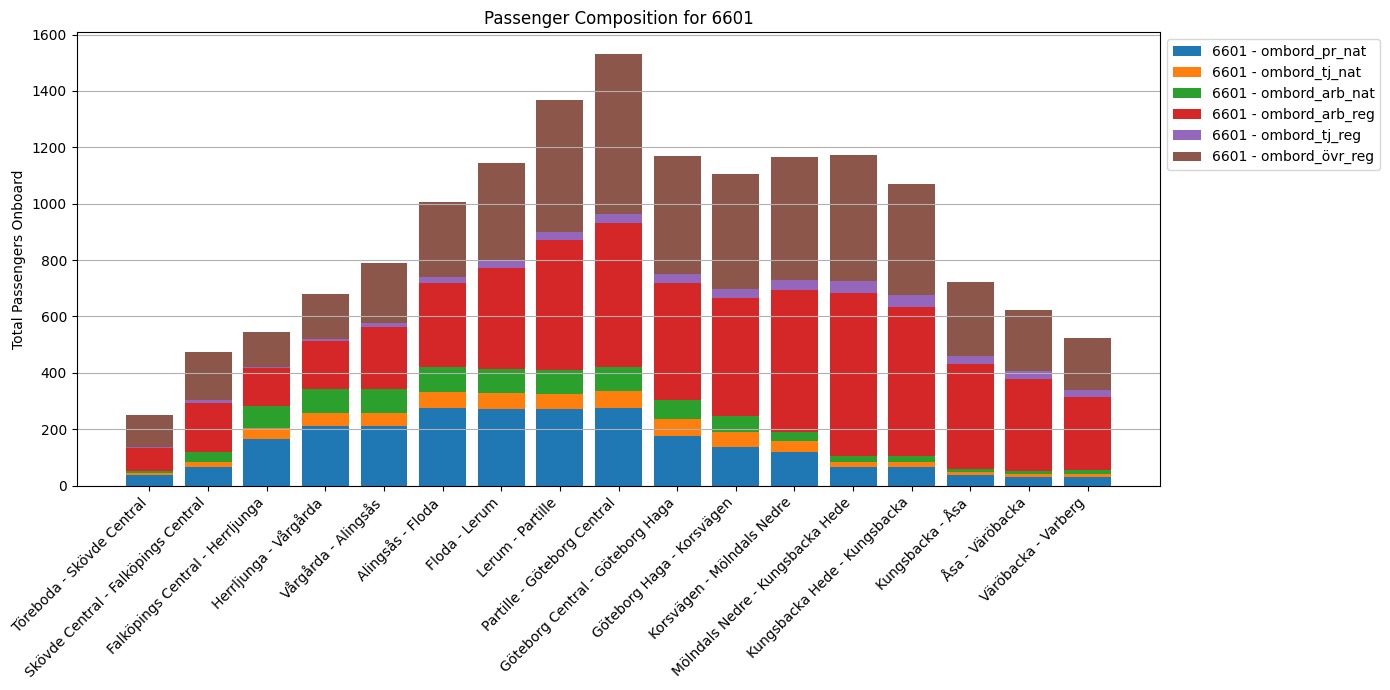

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Get a random line that has an inverse (remove 'R' suffixed lines from selection)
base_lines = [line for line in new_df_pax['Linje'].unique() if not line.endswith('R')]
random_line = np.random.choice(base_lines)

# Get data for the line
line_data = new_df_pax[new_df_pax['Linje'] == random_line]

# Calculate total passengers onboard for each type
onboard_cols = ['ombord_pr_nat', 'ombord_tj_nat', 'ombord_arb_nat', 
                'ombord_arb_reg', 'ombord_tj_reg', 'ombord_övr_reg']
onboard_types = line_data[onboard_cols]

# Create segment labels
segments = [f"{row['från']} - {row['till']}" for _, row in line_data.iterrows()]

# Set up bar positions
x = np.arange(len(segments))

# Create the bar chart
fig, ax = plt.subplots(figsize=(14, 7))

bottom = np.zeros(len(segments))
for col in onboard_cols:
    ax.bar(x, onboard_types[col], bottom=bottom, label=f"{random_line} - {col}")
    bottom += onboard_types[col]

# Formatting
ax.set_xticks(x)
ax.set_xticklabels(segments, rotation=45, ha='right')
ax.set_ylabel('Total Passengers Onboard')
ax.set_title(f'Passenger Composition for {random_line}')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.grid(True, axis='y')

plt.tight_layout()
plt.show()


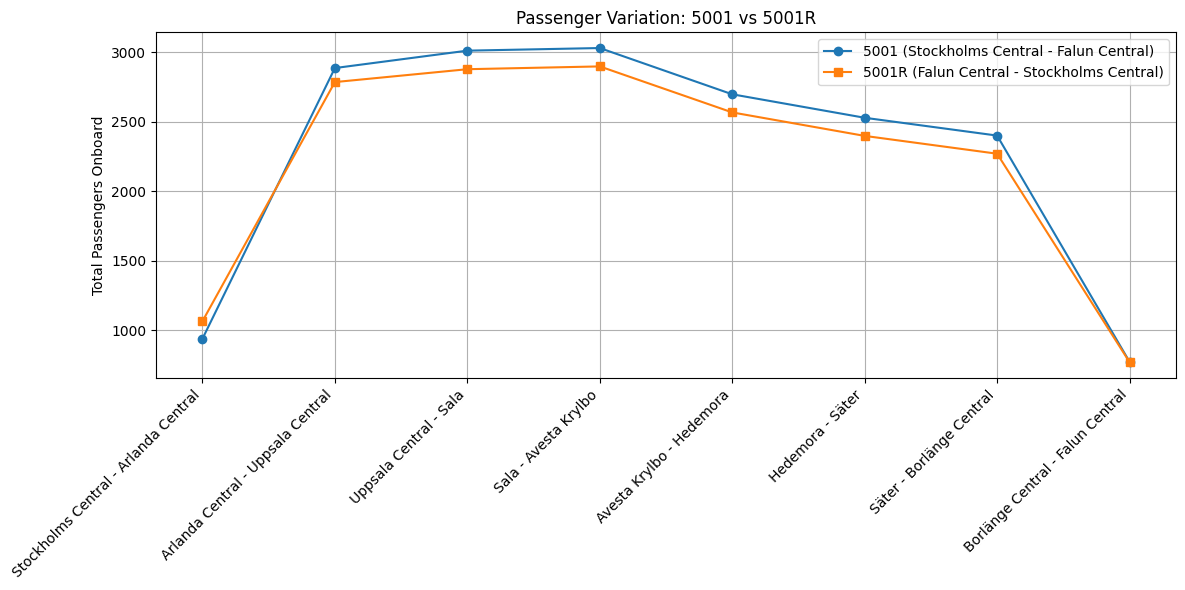

In [37]:
# do the same but plot the line and its inverse together
# Get a random line

import matplotlib.pyplot as plt
import numpy as np

# Get a random line that has an inverse (remove 'R' suffixed lines from selection)
base_lines = [line for line in new_df_pax['Linje'].unique() if not line.endswith('R')]
random_line = np.random.choice(base_lines)
inverse_line = random_line + 'R'

# Get data for both lines
line_data = new_df_pax[new_df_pax['Linje'] == random_line]
inverse_data = new_df_pax[new_df_pax['Linje'] == inverse_line]

# Calculate total passengers onboard
onboard_cols = ['ombord_pr_nat', 'ombord_tj_nat', 'ombord_arb_nat', 
                'ombord_arb_reg', 'ombord_tj_reg', 'ombord_övr_reg']
total_onboard = line_data[onboard_cols].sum(axis=1)
total_onboard_inverse = inverse_data[onboard_cols].sum(axis=1).iloc[::-1].reset_index(drop=True)
# total_onboard_inverse should be mirroed because the data is for the inverse line

# Create segment labels
segments = [f"{row['från']} - {row['till']}" for _, row in line_data.iterrows()]
segments_inverse = [f"{row['från']} - {row['till']}" for _, row in inverse_data.iterrows()]

plt.figure(figsize=(12, 6))
plt.plot(range(len(segments)), total_onboard, marker='o', label=f"{random_line} ({line_data['först'].unique()[0]} - {line_data['sist'].unique()[0]})")
plt.plot(range(len(segments_inverse)), total_onboard_inverse, marker='s', label=f"{inverse_line} ({inverse_data['först'].unique()[0]} - {inverse_data['sist'].unique()[0]})")
plt.xticks(range(max(len(segments), len(segments_inverse))), segments, rotation=45, ha='right')
plt.ylabel('Total Passengers Onboard')
plt.title(f'Passenger Variation: {random_line} vs {inverse_line}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

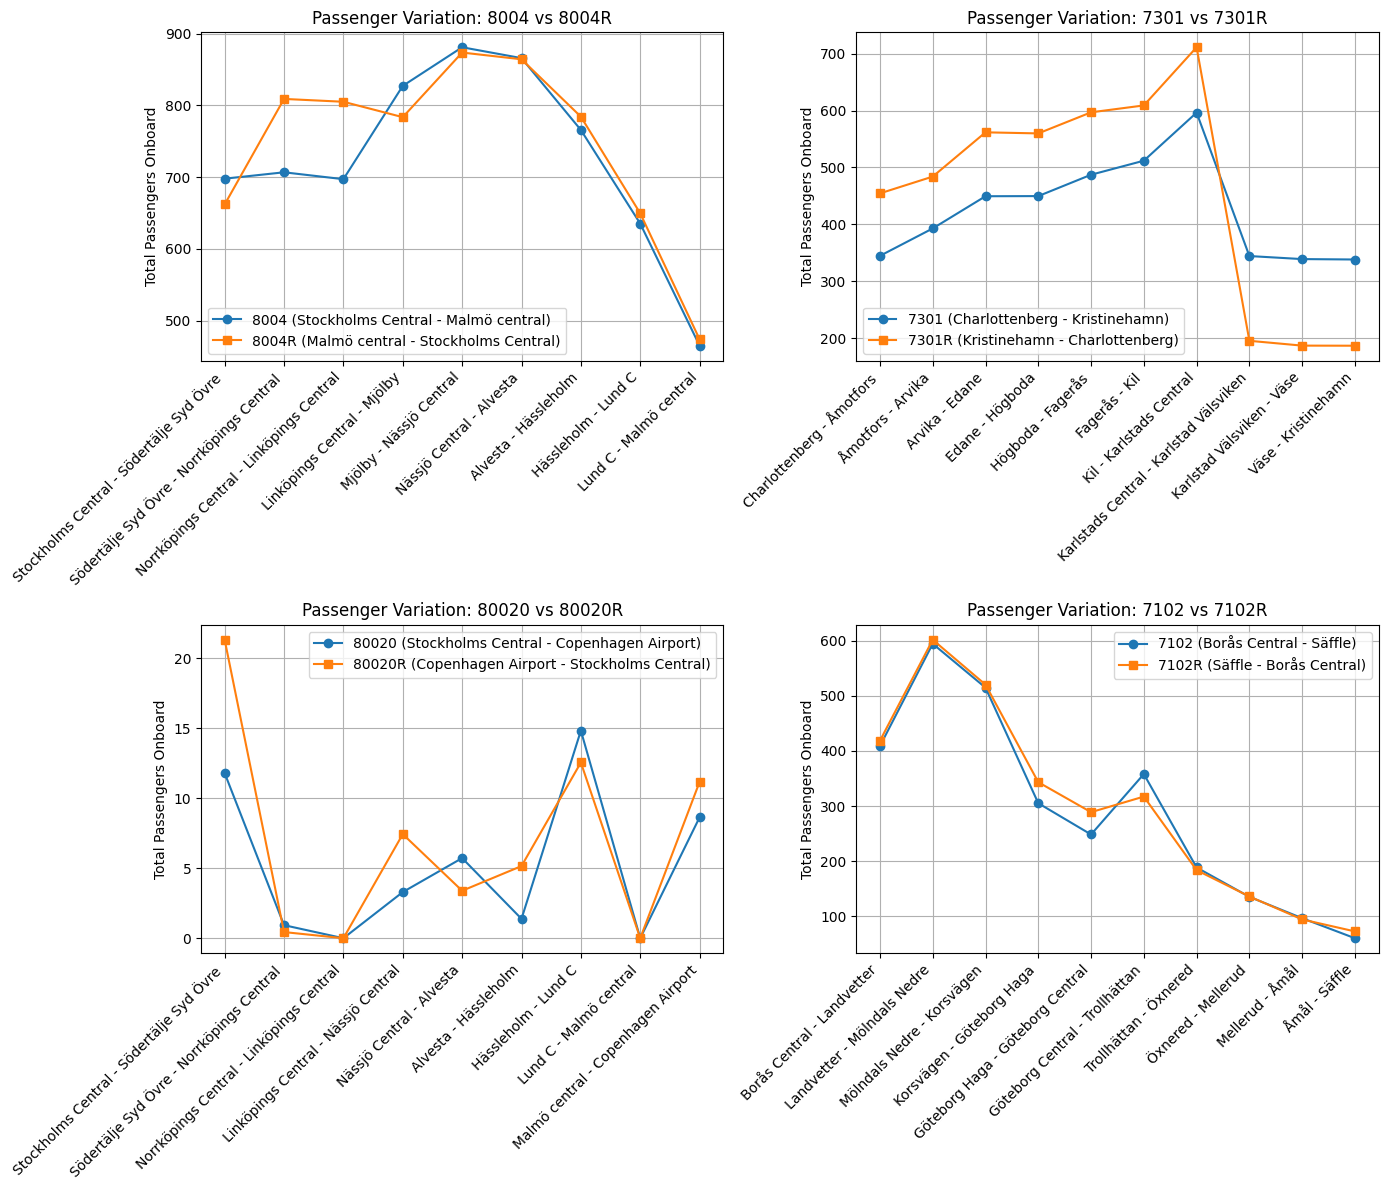

In [38]:
# do the same but for four random lines and their inverses, use a 2*2 figure to plot them
# Get four random lines that have inverses

import matplotlib.pyplot as plt
import numpy as np

# Get four random lines that have inverses
random_lines = np.random.choice(base_lines, 4)
random_lines_inverse = [line + 'R' for line in random_lines]

# Create a 2x2 subplot figure
fig, axs = plt.subplots(2, 2, figsize=(14, 12))

# Iterate through each random line and its inverse to plot
for i, (line, inverse_line) in enumerate(zip(random_lines, random_lines_inverse)):
    ax = axs[i // 2, i % 2]  # Determine the correct subplot (2x2)

    # Get data for both lines
    line_data = new_df_pax[new_df_pax['Linje'] == line]
    inverse_data = new_df_pax[new_df_pax['Linje'] == inverse_line]

    # Calculate total passengers onboard
    onboard_cols = ['ombord_pr_nat', 'ombord_tj_nat', 'ombord_arb_nat', 
                    'ombord_arb_reg', 'ombord_tj_reg', 'ombord_övr_reg']
    total_onboard = line_data[onboard_cols].sum(axis=1)
    total_onboard_inverse = inverse_data[onboard_cols].sum(axis=1).iloc[::-1].reset_index(drop=True)

    # Create segment labels
    segments = [f"{row['från']} - {row['till']}" for _, row in line_data.iterrows()]
    segments_inverse = [f"{row['från']} - {row['till']}" for _, row in inverse_data.iterrows()]

    # Plot the line and its inverse
    ax.plot(range(len(segments)), total_onboard, marker='o', label=f"{line} ({line_data['först'].unique()[0]} - {line_data['sist'].unique()[0]})")
    ax.plot(range(len(segments_inverse)), total_onboard_inverse, marker='s', label=f"{inverse_line} ({inverse_data['först'].unique()[0]} - {inverse_data['sist'].unique()[0]})")

    # Set x-axis labels, title, and other plot formatting
    ax.set_xticks(range(max(len(segments), len(segments_inverse))))
    ax.set_xticklabels(segments, rotation=45, ha='right')
    ax.set_ylabel('Total Passengers Onboard')
    ax.set_title(f'Passenger Variation: {line} vs {inverse_line}')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()


## Exporting to excel file

In [ ]:
# Ensure the 'line' column is treated as text (string type)
new_df_pax['Linje'] = new_df_pax['Linje'].astype(str)

# Save the DataFrame to an Excel file
output_filename = "static_pass_all_2024.xlsx"
new_df_pax.to_excel(output_filename, index=False)

print(f"Data successfully saved to {output_filename}")